In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dense, Conv2D
from keras.layers import  BatchNormalization, LeakyReLU, Dropout, Activation

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

## Loading CSV from Desktop

In [2]:
NUM_CLASSES = 2
CLASSES = np.array(['benign', 'malware'])
DATASET_DIR = "dataset/"
WIDTH = 256
HEIGHT = 256
SHAPE = (WIDTH, HEIGHT)
SIZE = WIDTH * HEIGHT * 1

def csvToimage(file_path):
    data = pd.read_csv(file_path)
    data_encoded = LabelEncoder().fit_transform(data['SYSTEM_CALL'])
    image = np.zeros(SHAPE, dtype=np.uint8)
    syscall_nums = min(len(data_encoded), SIZE)
    image.flat[:syscall_nums] = data_encoded[:syscall_nums]

    return image

def load_data(dataset_dir):
    x = []
    y = []

    classes = [class_name for class_name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, class_name))]
    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_dir, class_name)
        for file_name in os.listdir(class_dir):
            if file_name.endswith('.csv'):
                file_path = os.path.join(class_dir, file_name)
                image = csvToimage(file_path)
                x.append(image)
                y.append(class_idx)
                
    x = np.array(x).reshape(-1, WIDTH, HEIGHT, 1)
    y = np.array(y)
    return x, y

In [3]:
X, y = load_data(DATASET_DIR)

# Image Plotting

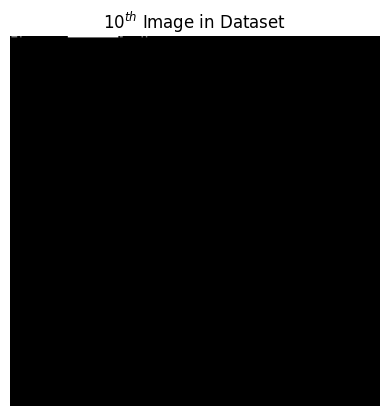

In [4]:
n = 10
nth_image = X[n].reshape(256, 256)

plt.imshow(nth_image, cmap='gray')
plt.title(f'${n}^{{th}}$ Image in Dataset')
plt.axis('off')
plt.show()


## Split and Nomalize Data

In [5]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train / 255.0
X_test = X_test / 255.0

y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

## Shape of Train, Test set

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(307, 256, 256, 1)
(132, 256, 256, 1)
(307, 2)
(132, 2)


## A Basic CNN Architecture

In [7]:
input_layer = Input((WIDTH, HEIGHT, 1))

x = Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Flatten()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Dense(NUM_CLASSES)(x)
output_layer = Activation('softmax')(x)

model = Model(input_layer, output_layer)

opt = Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



## model summary

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                             

## model train

In [9]:
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=100, 
          shuffle=True
)

Epoch 1/100


2023-12-05 02:50:29.728508: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


10/10 [==============================] - 12s 954ms/step - loss: 0.7233 - accuracy: 0.8306
Epoch 2/100
10/10 [==============================] - 7s 648ms/step - loss: 0.3565 - accuracy: 0.8632
Epoch 3/100
10/10 [==============================] - 6s 630ms/step - loss: 0.2948 - accuracy: 0.8893
Epoch 4/100
10/10 [==============================] - 6s 613ms/step - loss: 0.2596 - accuracy: 0.8893
Epoch 5/100
10/10 [==============================] - 7s 695ms/step - loss: 0.2456 - accuracy: 0.9055
Epoch 6/100
10/10 [==============================] - 7s 722ms/step - loss: 0.2213 - accuracy: 0.9251
Epoch 7/100
10/10 [==============================] - 7s 658ms/step - loss: 0.2130 - accuracy: 0.9218
Epoch 8/100
10/10 [==============================] - 7s 674ms/step - loss: 0.2021 - accuracy: 0.9446
Epoch 9/100
10/10 [==============================] - 7s 662ms/step - loss: 0.2067 - accuracy: 0.9283
Epoch 10/100
10/10 [==============================] - 7s 709ms/step - loss: 0.2028 - accuracy: 0.9381


## Evaluate

In [10]:
model.evaluate(X_test, y_test, batch_size=1000)

1/1 [==============================] - 1s 1s/step - loss: 8.2262 - accuracy: 0.4621


[8.226216316223145, 0.46212121844291687]

In [11]:
y_pred = model.predict(X_test)

5/5 [==============================] - 1s 125ms/step


In [12]:
preds_single = CLASSES[np.argmax(y_pred, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

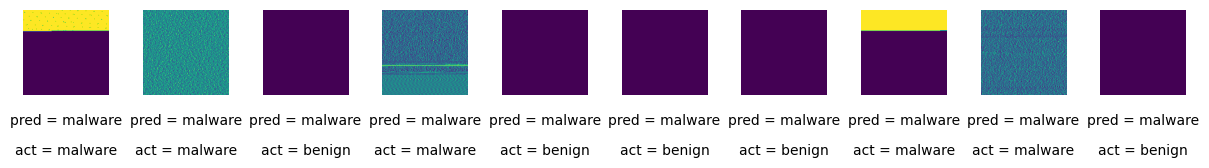

In [13]:
n_to_show = 10
indices = np.random.choice(range(len(X_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = X_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)

## Score

In [14]:
y_pred_classes = tf.argmax(y_pred, axis=1)
y_test_classes = tf.argmax(y_test, axis=1)

print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        71
           1       0.46      1.00      0.63        61

    accuracy                           0.46       132
   macro avg       0.23      0.50      0.32       132
weighted avg       0.21      0.46      0.29       132



/Users/gyeonghoon_park/miniforge3/envs/TF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gyeonghoon_park/miniforge3/envs/TF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gyeonghoon_park/miniforge3/envs/TF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier